In [1]:
import pandas as pd

In [2]:
from collections import Counter, OrderedDict
from nltk.tokenize import word_tokenize
import numpy as np
from tqdm import tqdm


def vocabulary(corpus, voc_threshold=0):
    """
    Function using word counts to build a vocabulary - can be improved with a second parameter for
    setting a frequency threshold
    Params:
        corpus (list of list of strings): corpus of sentences
        voc_threshold (int): maximum size of the vocabulary (0 means no limit !)
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency
    """
    # Setting limits
    voc_threshold = voc_threshold if voc_threshold else int(10e5)

    # Count each words of our corpus
    word_counts = dict(Counter(word_tokenize(" ".join(corpus))))

    # Sort them decreasingly
    sorted_word_counts = OrderedDict(
        sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
    )

    # Create our vocabulary (no more than the parameter voc_threshold)
    vocabulary_word_counts = dict(list(sorted_word_counts.items())[:voc_threshold])

    vocabulary = {
        list(vocabulary_word_counts.keys())[i]: i
        for i in range(len(vocabulary_word_counts))
    }

    # Add 'Unknown' word
    vocabulary = {**vocabulary, "UNK": len(vocabulary_word_counts)}
    vocabulary_word_counts = {**vocabulary_word_counts, "UNK": 0}

    return vocabulary, vocabulary_word_counts


def co_occurence_matrix(corpus, vocabulary, window=0, distance_weighting=False):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
        distance_weighting (bool): indicates if we use a weight depending on the distance between words for co-oc counts
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input
    """
    l = len(vocabulary)
    M = np.zeros((l, l))
    for sent in tqdm(corpus, desc="co-occurence matrix"):
        # Get the sentence as a list of words
        sent = word_tokenize(sent)
        # Obtain the indexes of the words in the sentence from the vocabulary
        sent_idx = [vocabulary[word] if word in vocabulary else -1 for word in sent]
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = sent_idx[max(i - window, 0) : i]
            # If the context = ... is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = sent_idx[:i]
            # Go through the list and update M[i,j]:
            for j, idx_j in enumerate(l_ctx_idx):
                # We know the word is in the vocabulary
                if j > -1:
                    weight = 1.0
                    if distance_weighting:
                        weight /= abs(i - j)
                    M[idx, idx_j] += weight * 1.0
                    M[idx_j, idx] += weight * 1.0
                # Unkwnown word
                else:
                    weight = 1.0
                    if distance_weighting:
                        weight /= abs(i - j)
                    M[idx, l] += weight * 1.0
                    M[l, idx] += weight * 1.0
    return M


def euclidean(u, v):
    return np.linalg.norm(u - v)


def length_norm(u):
    return u / np.sqrt(u.dot(u))


def cosine(u, v):
    return 1.0 - length_norm(u).dot(length_norm(v))


def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise,
        like `np.mean`, `np.sum`, or `np.prod`.
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`
    """
    representations = np.zeros((len(texts), embeddings.shape[1]))
    count = 0
    for text in tqdm(texts):
        vec_rep = list(
            map(
                lambda x: embeddings[vocabulary[x]]
                if (x in vocabulary.keys())
                else embeddings[vocabulary["UNK"]],
                text.split(),
            )
        )
        vec_rep_2D = np.stack(vec_rep, axis=0)
        transform_vec = np_func(vec_rep_2D, axis=0)
        representations[count] = transform_vec
        count += 1
    return representations

In [3]:
"""NLP Challenge utils."""

import os
from pathlib import Path


def set_working_dir():
    """Set working dir for Jupyter."""
    cwd = Path(os.getcwd())
    print(f"Current working dir: {cwd.as_posix()}")
    if Path(cwd).name == "notebooks":
        new_cwd = Path(cwd).parent
        os.chdir(new_cwd)
        print(f"New working dir: {new_cwd.as_posix()}")


In [4]:
import re
import contractions
import nltk
import pandas as pd

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


def load_data(dict_path):
    df_ecb = pd.read_csv(dict_path["ecb"], index_col=0)
    df_fed = pd.read_csv(dict_path["fed"], index_col=0)
    df_train_series = pd.read_csv(dict_path["train_series"], index_col=0)
    return df_ecb, df_fed, df_train_series


def get_wordnet_pos(tag: str) -> str:
    """_summary_
    TODO docstring

    Parameters
    ----------
    tag : str
        _description_

    Returns
    -------
    str
        _description_
    """
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def text_cleaning(
    corpus: str,
    negation_set,
    fg_no_numbers: bool = False,
    fg_stop_words: bool = False,
    fg_lemmatization: bool = False,
):
    """Text cleaning of a corpus and extraction of mentions and hashtags

    Parameters
    ----------
    corpus : str
        String to clean
    negation_set : set[str]
        Negation words
    fg_no_numbers: bool, optional
        Remove the numbers
    fg_stop_words : bool, optional
        Remove or not stop words, by default False
    fg_lemmatization : bool, optional
        Apply or not lemmatization, by default False

    Returns
    -------
    tuple[str, list[str], list[str]]
        corpus : Cleaned string
        mentions : List of mentionned users in the corpus (@'s)
        hashtags : List of hashtags in the corpuss (#'s)
    """

    # lowercase
    corpus = corpus.lower()

    # remove extra newlines
    corpus = re.sub(r"[\r|\n|\r\n]+", " ", corpus)

    # remove URL
    corpus = re.sub(r"https?://[\S]+", "", corpus)

    # remove contractions
    corpus = " ".join([contractions.fix(x) for x in corpus.split()])

    # Remove @ # and any special chars
    corpus = re.sub(r"[\W_]+", " ", corpus)

    # remove numbers
    if fg_no_numbers:
        corpus = re.sub(r" \d+", " ", corpus)

    # tokenization
    corpus_words = word_tokenize(corpus)

    if fg_stop_words:
        # remove stop words
        stop_words = set(stopwords.words("english")).difference(negation_set)
        corpus_words = [word for word in corpus_words if word not in stop_words]

    if fg_lemmatization:
        # lemmatization
        corpus_pos_tag = nltk.tag.pos_tag(corpus_words)
        corpus_pos_tag = [
            (word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in corpus_pos_tag
        ]
        wordnet_lemmatizer = WordNetLemmatizer()
        corpus_words = [
            wordnet_lemmatizer.lemmatize(word, tag) for (word, tag) in corpus_pos_tag
        ]

    return " ".join(corpus_words)


def categorical_other(df_cat_column, threshold=0.02, name_cat_rare="other"):
    """
    Map the rare categorical variable to 'Other' based on their frequency

    Arguments
    ---------
        df_cat_colum: pd.Series
            Categorical column
        threshold: float32
            Threshold of frequency to map to the rare category
        name_cat_rare: str
            Name of the rare category
    Returns
    -------
        df_cat_other: pd.Series
            Modified categorical column
    """
    # Frequency of categorical category
    df_freq = df_cat_column.value_counts(normalize=True)
    # Replace cat by its frequency
    df_map = df_cat_column.map(df_freq)
    # If inferior to threshold -> replace it
    df_cat_other = df_cat_column.mask(df_map < threshold, name_cat_rare)
    return df_cat_other


def link_texts_series(df_train_series, df_text, id_series, id_text):
    """
    Using the text indices of a time series, concatenate the text

    Arguments
    ---------
        df_train_series: pd.DataFrame
            Times Series with a text index column
        df_text: pd.DataFrame
            Dataframe storing the texts
        id_series: str
            Name of the column of the Unique identifier of the series
        id_text: str
            Name of the column of the Unique identifier of the texts
    Returns
    -------
        df_conc: pd.DataFrame
            Dataframe containing the time series and the concatenated text
    """
    # Copy our dataframe
    df_temp = df_text.copy()
    suff = id_text.split("_")[1]
    # Unnest the list of texts for each times series
    df_temp = df_train_series.explode(id_text)
    # Convert the Id to Int
    df_temp[id_text] = df_temp[id_text].astype("int64")
    # Join the list and series on the id_texts (previously unnested)
    df_temp = df_temp.merge(df_text, on=id_text, how="left")
    # Group By the series and aggregate on specific features (concatenate the text, list of the speakers)
    df_temp = (
        df_temp.groupby(id_series)
        .agg({"text_process": lambda x: " ".join(x), "speaker": lambda x: list(x)})
        .reset_index()
        .rename(
            columns={
                "text_process": "text_concat_" + suff,
                "speaker": "list_speakers_" + suff,
            }
        )
    )
    return df_temp


def suppr_footnotes(text):
    """
    Description : fonction pour supprimer les footnotes d'un texte (références biblio, etc)  (à vérifier si permet de supprimer toutes les footnotes)
    - input : colonne 'text'
    - output : colonne 'text' modifiée afin de supprimer les footnotes / citations

    """

    txt = text
    #
    try:

        txt_list = txt.split("References", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    try:
        txt_list = txt.split("Footnotes", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    try:
        txt_list = txt.split("      [1]", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    try:
        txt_list = txt.split("See also footnotes", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    try:
        txt_list = txt.split(" References ", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    ##
    """try:
        txt_list = txt.split(" 1. ", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass"""

    try:
        txt_list = txt.split("SEE ALSO", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    #
    """try:
        txt_list = txt.split("See also", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass"""

    try:
        txt_list = txt.split("Thank you. ", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    try:
        txt_list = txt.split("Thank you for your attention.  ", maxsplit=1)
        if len(txt) > 1:
            txt = txt_list[0]
        else:
            1 / 0
    except:
        pass

    return txt


In [5]:
from pathlib import Path


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
#from category_encoders import WOEEncoder

# Load Data

In [6]:
path = Path("data")
files_path = {
    "ecb": './data/ecb_data.csv',
    "fed": './data/fed_data.csv',
    "train_series": './data/train_series.csv',
}

In [7]:
# LOAD TEXT DATA
df_ecb, df_fed, df_train_series = load_data(files_path)
print(df_ecb.shape, df_fed.shape, df_train_series.shape)

(1772, 3) (739, 3) (8946, 14)


# Text Cleaning

## Link Texts to Series

Create some indices

In [8]:
df_ecb.reset_index(inplace=True, names="id_ecb")
df_fed.reset_index(inplace=True, names="id_fed")  
df_train_series.reset_index(inplace=True, names="id_series")


Create a list rather than a string with a comma separator

In [9]:
df_train_series["id_ecb"] = [x.split(",") for x in df_train_series['index ecb']]
df_train_series["id_fed"] = [x.split(",") for x in df_train_series['index fed']]
del df_train_series['index ecb']
del df_train_series['index fed']

## Remove Footnotes

In [10]:
df_ecb["text_process"] = df_ecb.text.apply(lambda x: suppr_footnotes(x))
df_fed["text_process"] = df_fed.text.apply(lambda x: suppr_footnotes(x))

## Deal with Null Values

In [11]:
# REPLACE NULL TEXTS BY TITLE
index_no_texts = df_ecb[df_ecb["text_process"].isnull()].index.values
df_ecb.loc[index_no_texts, "text_process"] = df_ecb.loc[index_no_texts, "title"].values

## Remove special characters, stop words, Lemmatization...

In [12]:
negation_words = ["no", "not"]
df_fed.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    ) for x in df_fed.text_process]
df_ecb.text_process = [text_cleaning(
        x,
        negation_set=negation_words,
        fg_no_numbers=True,
        fg_stop_words=True,
        fg_lemmatization=True,
    ) for x in df_ecb.text_process]

# Text Concatenation

In [13]:
df_train_series.head()

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index + 1,id_ecb,id_fed
0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,0.054050,0.015779,0.010597,"[1126, 1471]",[96]
1,1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,0.007422,0.000000,0.014492,[975],[568]
2,2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,0.005040,0.000156,0.016263,"[78, 806]","[328, 695]"
3,3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,0.001018,-0.002582,0.013581,"[560, 1405]",[118]
4,4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,-0.000729,-0.000365,0.005092,[404],[261]


In [14]:
df_series_ecb_process = link_texts_series(df_train_series, df_ecb, "id_series", "id_ecb")
df_series_fed_process = link_texts_series(df_train_series, df_fed, "id_series", "id_fed")

In [15]:
df_train_series = df_train_series.merge(df_series_ecb_process,on='id_series',how='left')
df_train_series = df_train_series.merge(df_series_fed_process,on='id_series',how='left')
df_train_series.head()

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index + 1,id_ecb,id_fed,text_concat_ecb,list_speakers_ecb,text_concat_fed,list_speakers_fed
0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,0.054050,0.015779,0.010597,"[1126, 1471]",[96],welcome address welcome remark philip r lane m...,"[Philip R. Lane, Luis de Guindos]",delighted helsinki important conference moneta...,[Vice Chairman Richard H. Clarida]
1,1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,0.007422,0.000000,0.014492,[975],[568],monetary policy structural reform euro area sp...,[Mario Draghi],watch live would like thank federal reserve ba...,[Vice Chairman Stanley Fischer]
2,2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,0.005040,0.000156,0.016263,"[78, 806]","[328, 695]",challenge opportunity reboot european financia...,"[Benoît Cœuré, Benoît Cœuré]",grateful national association business economi...,"[Vice Chairman Stanley Fischer, Governor Lael ..."
3,3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,0.001018,-0.002582,0.013581,"[560, 1405]",[118],create stability uncertain world speech peter ...,"[Peter Praet, Peter Praet]",thank invitation speak today begin take stock ...,[Governor Jerome H. Powell]
4,4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,-0.000729,-0.000365,0.005092,[404],[261],money private currency reflection libra speech...,[Yves Mersch],year symposium topic challenge monetary policy...,[Chairman Jerome H. Powell]


In [16]:
df_train_series[df_train_series['Index Name'] == 'V2X Index']

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,Index - 1,Index - 0,Index + 1,id_ecb,id_fed,text_concat_ecb,list_speakers_ecb,text_concat_fed,list_speakers_fed
0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,0.054050,0.015779,0.010597,"[1126, 1471]",[96],welcome address welcome remark philip r lane m...,"[Philip R. Lane, Luis de Guindos]",delighted helsinki important conference moneta...,[Vice Chairman Richard H. Clarida]
11,11,V2X Index,-0.035787,0.104474,-0.028211,-0.074643,-0.039099,0.047375,-0.013441,0.070540,-0.033561,0.019054,-0.035494,[490],"[83, 87, 584]",speech may international inflation co movement...,[Philip R. Lane],th fed listen event federal reserve conduct mo...,"[Governor Lael Brainard, Chairman Jerome H. Po..."
20,20,V2X Index,0.022172,0.088830,0.049455,-0.078292,-0.065107,-0.041420,-0.062218,-0.053103,0.122130,-0.061635,-0.037761,[59],[402],consistent strategy sustain recovery lecture m...,[Mario Draghi],honor pleasure mark woman history month histor...,[Chair Janet L. Yellen]
22,22,V2X Index,0.009448,-0.094203,0.083527,0.099826,0.005094,-0.040837,-0.005840,-0.093532,0.003805,-0.007379,0.039252,[404],[261],money private currency reflection libra speech...,[Yves Mersch],year symposium topic challenge monetary policy...,[Chairman Jerome H. Powell]
23,23,V2X Index,-0.058124,-0.046877,-0.001162,-0.001315,0.018090,0.014173,-0.044225,-0.074017,-0.006363,0.040413,-0.048734,[1185],[484],hear committee economic monetary affair europe...,[Mario Draghi],watch live real world crises way shake intelle...,[Governor Daniel K. Tarullo]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921,8921,V2X Index,0.107613,0.080254,0.119479,-0.019587,-0.089864,0.030332,0.020470,-0.087496,-0.032233,-0.000372,-0.040900,[1116],"[722, 243]",presentation ecb annual report committee econo...,[Luis de Guindos],thank conference state bank supervisor csbs op...,"[Governor Michelle W. Bowman, Vice Chair for S..."
8922,8922,V2X Index,0.036843,-0.067023,-0.021908,-0.036491,-0.142792,0.058384,0.126327,0.077261,-0.061374,0.140333,-0.124505,[851],[472],monetary policy euro area speech mario draghi ...,[Mario Draghi],nine year expansion sometimes proceed slowly e...,[Chairman Jerome H. Powell]
8927,8927,V2X Index,-0.050264,-0.052118,-0.060318,0.096750,0.016706,-0.006463,-0.078094,0.003348,-0.085034,-0.037485,-0.030513,[447],[51],role effect ecb non standard policy measure re...,[Vítor Constâncio],overall economy remain solid footing backdrop ...,[Governor Lael Brainard]
8933,8933,V2X Index,-0.060792,0.048623,0.149260,-0.010543,0.000000,0.000000,0.181423,-0.039464,-0.065835,0.062966,-0.018711,"[698, 119]",[82],retos de la nueva europa la culminación de la ...,"[José Manuel González-Páramo, Jörg Asmussen]",would like thank conference organizer opportun...,[Chairman Ben S. Bernanke]


# Tokenisation


On va désormais procéder à l'étape de tokenisation de notre texte. La tokenization permet de transformer le texte brut en une liste de tokens, qui peuvent être analysés par la suite lors de l'analyse des sentiments. En divisant le texte en unités de sens plus petites, la tokenization permet également de réduire la complexité du texte et de faciliter son analyse.

In [17]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Création d'une fonction de tokenisation
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Appliquer la fonction de tokenisation à chaque ligne de la colonne "
df_train_series['text_concat_ecb_tokenisé'] = df_train_series['text_concat_ecb'].apply(tokenize_text)
df_train_series['text_concat_fed_tokenisé'] = df_train_series['text_concat_fed'].apply(tokenize_text)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
df_train_series['text_concat_fed_tokenisé'].head()

0    [delighted, helsinki, important, conference, m...
1    [watch, live, would, like, thank, federal, res...
2    [grateful, national, association, business, ec...
3    [thank, invitation, speak, today, begin, take,...
4    [year, symposium, topic, challenge, monetary, ...
Name: text_concat_fed_tokenisé, dtype: object

In [19]:
# On crée une nouvelle colonne appelé 'V_Cible_categ', rendant catégorielle notre variable cible (pour la classification)

df_train_series['V_Cible_categ'] = df_train_series['Index + 1'].apply(lambda x: 'Hausse' if x > 0 else 'Baisse')
df_train_series['V_Cible_categ']

0       Hausse
1       Hausse
2       Hausse
3       Hausse
4       Hausse
         ...  
8941    Baisse
8942    Baisse
8943    Hausse
8944    Baisse
8945    Hausse
Name: V_Cible_categ, Length: 8946, dtype: object

# Sentiment Analysis


## Loughan and McDonald

In [20]:
# Loughan and McDonald Dictionnary

import pysentiment2 as ps
lm = ps.LM()
def get_sentiment_score(text):
  tokens = lm.tokenize(text)
  score = lm.get_score(tokens)
  return score


# ajout de colonnes pour le score de polarité
df_train_series['polarity_score_ecb_LM'] = df_train_series['text_concat_ecb_tokenisé'].apply(lambda x: get_sentiment_score(' '.join(x)))
df_train_series['polarity_score_fed_LM'] = df_train_series['text_concat_fed_tokenisé'].apply(lambda x: get_sentiment_score(' '.join(x)))



In [21]:
df_train_series['polarity_score_fed_LM']

0       {'Positive': 57, 'Negative': 84, 'Polarity': -...
1       {'Positive': 40, 'Negative': 96, 'Polarity': -...
2       {'Positive': 114, 'Negative': 255, 'Polarity':...
3       {'Positive': 71, 'Negative': 132, 'Polarity': ...
4       {'Positive': 69, 'Negative': 140, 'Polarity': ...
                              ...                        
8941    {'Positive': 60, 'Negative': 170, 'Polarity': ...
8942    {'Positive': 100, 'Negative': 198, 'Polarity':...
8943    {'Positive': 83, 'Negative': 158, 'Polarity': ...
8944    {'Positive': 127, 'Negative': 252, 'Polarity':...
8945    {'Positive': 8, 'Negative': 22, 'Polarity': -0...
Name: polarity_score_fed_LM, Length: 8946, dtype: object

In [22]:
df_train_series['polarity_fed_LM'] = df_train_series['polarity_score_fed_LM'].apply(lambda x: x['Polarity'])
df_train_series['polarity_ecb_LM'] = df_train_series['polarity_score_ecb_LM'].apply(lambda x: x['Polarity'])
df_train_series['polarity_ecb_LM'].head()

0   -0.079545
1    0.019608
2   -0.213675
3    0.000000
4   -0.264368
Name: polarity_ecb_LM, dtype: float64

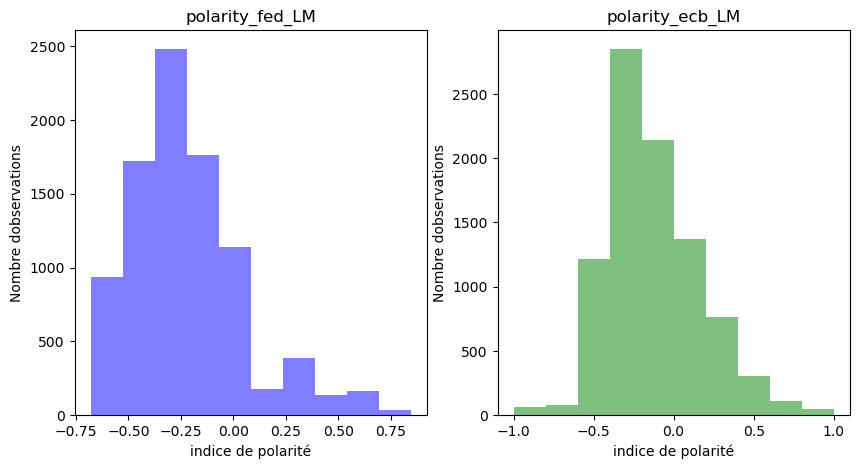

In [23]:
# On trace une représentation graphique de la répartition des scores de polarité

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.hist(df_train_series['polarity_fed_LM'], color='blue', alpha=0.5)
ax1.set(title='polarity_fed_LM', xlabel='indice de polarité', ylabel='Nombre dobservations')

ax2.hist(df_train_series['polarity_ecb_LM'], color='green', alpha=0.5)
ax2.set(title='polarity_ecb_LM', xlabel='indice de polarité', ylabel='Nombre dobservations')

plt.show()

In [24]:
# ajout de colonnes pour l'étiquetage des sentiments
df_train_series['sentiment_label_ecb_LM'] = df_train_series['polarity_ecb_LM'].apply(lambda x: 'positive' if x > 0.1 else 'negative' if x < -0.1 else 'neutral')
df_train_series['sentiment_label_fed_LM'] = df_train_series['polarity_fed_LM'].apply(lambda x: 'positive' if x > 0.1 else 'negative' if x < -0.1 else 'neutral')
def ma_fonction(a, b):
  if a+b > 0.1:
    return 'positive'
  elif a+b< 0.1:
    return 'negative'
  else:
    return 'neutral'
 


df_train_series['sentiment_label_LM'] = df_train_series.apply(lambda row: ma_fonction(row['polarity_ecb_LM'],row['polarity_fed_LM']),axis=1)



In [25]:
df_train_series['sentiment_label_LM'].value_counts()

negative    7803
positive    1143
Name: sentiment_label_LM, dtype: int64

In [26]:
# Matrice de confusion
print('Matrice de confusion pour text fed')
table_fed = pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_ecb_LM'])
print(table_fed)
print('Matrice de confusion pour text ecb')
table_ecb = pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_fed_LM'])
print(table_ecb)
print('Matrice de confusion pour text ecb+fed')
table = pd.crosstab(df_train_series['V_Cible_categ'], df_train_series['sentiment_label_LM'])
print(table)

Matrice de confusion pour text fed
sentiment_label_ecb_LM  negative  neutral  positive
V_Cible_categ                                      
Baisse                      2846     1173       911
Hausse                      2293     1023       700
Matrice de confusion pour text ecb
sentiment_label_fed_LM  negative  neutral  positive
V_Cible_categ                                      
Baisse                      3706      754       470
Hausse                      3017      587       412
Matrice de confusion pour text ecb+fed
sentiment_label_LM  negative  positive
V_Cible_categ                         
Baisse                  4327       603
Hausse                  3476       540


On voit clairement que l'analyse des sentiment est efficace ici ! Un texte étiqueté 'positive' aura tendance à être associé à une hausse la ou un texte étiqueté 'négative' aura tendance à être associé à une baisse.

In [27]:
df_train_series

,id_series,Index Name,Index - 9,Index - 8,Index - 7,Index - 6,Index - 5,Index - 4,Index - 3,Index - 2,...,text_concat_ecb_tokenisé,text_concat_fed_tokenisé,V_Cible_categ,polarity_score_ecb_LM,polarity_score_fed_LM,polarity_fed_LM,polarity_ecb_LM,sentiment_label_ecb_LM,sentiment_label_fed_LM,sentiment_label_LM
0,0,V2X Index,0.001045,0.005841,0.003832,-0.027519,-0.103565,-0.045086,-0.011265,0.005164,...,"[welcome, address, welcome, remark, philip, r,...","[delighted, helsinki, important, conference, m...",Hausse,"{'Positive': 81, 'Negative': 95, 'Polarity': -...","{'Positive': 57, 'Negative': 84, 'Polarity': -...",-0.191489,-0.079545,neutral,negative,negative
1,1,MOVE Index,-0.021497,0.007891,-0.013175,-0.008436,0.000000,0.026303,0.000556,0.001455,...,"[monetary, policy, structural, reform, euro, a...","[watch, live, would, like, thank, federal, res...",Hausse,"{'Positive': 78, 'Negative': 75, 'Polarity': 0...","{'Positive': 40, 'Negative': 96, 'Polarity': -...",-0.411765,0.019608,neutral,negative,negative
2,2,SPX Index,-0.001872,-0.008154,0.023588,0.004086,0.003493,0.003300,0.000885,-0.011304,...,"[challenge, opportunity, reboot, european, fin...","[grateful, national, association, business, ec...",Hausse,"{'Positive': 92, 'Negative': 142, 'Polarity': ...","{'Positive': 114, 'Negative': 255, 'Polarity':...",-0.382114,-0.213675,negative,negative,negative
3,3,SPX Index,0.004980,-0.000864,0.001677,0.000000,0.006030,-0.001083,0.000419,0.001492,...,"[create, stability, uncertain, world, speech, ...","[thank, invitation, speak, today, begin, take,...",Hausse,"{'Positive': 136, 'Negative': 136, 'Polarity':...","{'Positive': 71, 'Negative': 132, 'Polarity': ...",-0.300493,0.000000,neutral,negative,negative
4,4,EURUSD Curncy,0.000360,-0.001893,0.005579,-0.003056,-0.001171,-0.001623,-0.002350,-0.006444,...,"[money, private, currency, reflection, libra, ...","[year, symposium, topic, challenge, monetary, ...",Hausse,"{'Positive': 32, 'Negative': 55, 'Polarity': -...","{'Positive': 69, 'Negative': 140, 'Polarity': ...",-0.339713,-0.264368,negative,negative,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8941,8941,SPX Index,-0.002045,-0.003642,0.008096,0.004949,-0.001264,0.000150,0.002482,0.000000,...,"[bank, union, future, bank, speech, vítor, con...","[illustrate, quite, literally, chart, new, yor...",Baisse,"{'Positive': 56, 'Negative': 63, 'Polarity': -...","{'Positive': 60, 'Negative': 170, 'Polarity': ...",-0.478261,-0.058824,neutral,negative,negative
8942,8942,SX5E Index,-0.027361,0.094386,0.002350,-0.005076,0.022555,0.000963,-0.060170,0.028323,...,"[restart, market, case, interbank, market, spe...","[financial, system, turmoil, past, month, cred...",Baisse,"{'Positive': 84, 'Negative': 196, 'Polarity': ...","{'Positive': 100, 'Negative': 198, 'Polarity':...",-0.328859,-0.400000,negative,negative,negative
8943,8943,SX5E Index,-0.008359,0.021658,-0.015986,-0.023528,0.020072,0.017822,0.005648,0.017045,...,"[challenge, opportunity, reboot, european, fin...","[paper, review, federal, open, market, committ...",Hausse,"{'Positive': 92, 'Negative': 142, 'Polarity': ...","{'Positive': 83, 'Negative': 158, 'Polarity': ...",-0.311203,-0.213675,negative,negative,negative
8944,8944,SRVIX Index,0.011945,0.002567,0.000000,0.005115,0.000364,0.003999,0.012978,0.012458,...,"[speech, occasion, annual, danish, top, execut...","[thank, claudia, thanks, american, economic, a...",Baisse,"{'Positive': 131, 'Negative': 194, 'Polarity':...","{'Positive': 127, 'Negative': 252, 'Polarity':...",-0.329815,-0.193846,negative,negative,negative


In [28]:
df_train_series.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8946 entries, 0 to 8945
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_series                 8946 non-null   int64  
 1   Index Name                8946 non-null   object 
 2   Index - 9                 8946 non-null   float64
 3   Index - 8                 8946 non-null   float64
 4   Index - 7                 8946 non-null   float64
 5   Index - 6                 8946 non-null   float64
 6   Index - 5                 8946 non-null   float64
 7   Index - 4                 8946 non-null   float64
 8   Index - 3                 8946 non-null   float64
 9   Index - 2                 8946 non-null   float64
 10  Index - 1                 8946 non-null   float64
 11  Index - 0                 8946 non-null   float64
 12  Index + 1                 8946 non-null   float64
 13  id_ecb                    8946 non-null   object 
 14  id_fed  

In [29]:
df_train = df_train_series.drop(columns=['text_concat_ecb', 'text_concat_fed', 'text_concat_ecb_tokenisé', 'text_concat_fed_tokenisé'])

In [32]:
df_train.to_csv('processed_data.csv', sep=',', encoding='utf-8', index=False)

# Train Test Split

In [ ]:
# Train test split 
X=df_train_series.loc[:,df_train_series.columns!="Index + 1"]
y=df_train_series[["Index + 1"]]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)
print(X_train.shape,y_train.shape)

Binary Classification

In [ ]:
y_t = np.sign(y_train)
y_t.value_counts()

In [ ]:
from pandas.plotting import lag_plot
lag_plot(series)
pyplot.show()

# Categorical Encoding 

In [ ]:
col_speakers = ["speaker_"+str(i+1) for i in range(4)]
test_conc = pd.concat([X_train, X_train['list_speakers_ecb'].apply(pd.Series)], axis=1)
test_conc.rename({i:col for i, col in enumerate(col_speakers)},axis=1,inplace=True)
enc = WOEEncoder(cols=col_speakers)
tr = enc.fit_transform(test_conc, y_t)
tr.fillna(0,inplace=True)

In [ ]:
tr.head()

# Embeddings

## Build a vocabulary

## Create the co-occurence Matrix

## Embeddings from the co-occurence Matrix

### SVD

## Sentence Representations

# Save Data